In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats

# ตั้งค่า matplotlib ตามที่ระบุ
font = {'size': 16}
plt.rc('font', **font)

In [2]:
# ฟังก์ชันตรวจจับ Moonshot และคำนวณ % การเปลี่ยนแปลงราคาหลัง Peak
def detect_moonshot_and_price_change(data, window=12, threshold=0.05, post_hours=[6, 12, 24, 48, 72]):
    moonshots = []
    for i in range(len(data) - window - max(post_hours)):
        if moonshots and (data.index[i] - moonshots[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Moonshot ใหม่เริ่มภายใน 12 ชั่วโมงจากครั้งก่อน
        
        close_price = data['close'].iloc[i]
        high_price = data['high'].iloc[i:i+window].max()
        low_price = data['low'].iloc[i:i+window].min()
        moonshot_pct = (high_price - close_price) / close_price
        if moonshot_pct >= threshold and (low_price - close_price) / close_price > -0.03:
            # หา index ของ High ภายใน Window
            high_idx = data['high'].iloc[i:i+window].idxmax()
            high_time = high_idx
            high_value = data.loc[high_idx, 'high']
            # คำนวณ % การเปลี่ยนแปลงราคาหลัง Peak
            price_changes = {}
            for h in post_hours:
                try:
                    # หา Close Price หลังจาก Peak ไป h ชั่วโมง
                    target_time = high_time + pd.Timedelta(hours=h)
                    closest_idx = data.index.get_indexer([target_time], method='nearest')[0]
                    close_after = data['close'].iloc[closest_idx]
                    price_change_pct = (close_after - high_value) / high_value * 100
                    price_changes[f'change_{h}h'] = price_change_pct
                except:
                    price_changes[f'change_{h}h'] = np.nan  # กรณีไม่มีข้อมูล
            moonshots.append({
                'start_time': data.index[i],
                'peak_time': high_time,
                'close_price': close_price,
                'high_price': high_value,
                'moonshot_pct': moonshot_pct * 100,
                **price_changes
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(moonshots)

In [3]:
# อ่านข้อมูลจากไฟล์ pickle
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))
data = data["2020-01-01":]  # กรองข้อมูลตั้งแต่ปี 2020
# ตั้ง index เป็น DatetimeIndex ถ้ายังไม่ได้ตั้ง
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data['time'])
# เลือกคอลัมน์ที่จำเป็น
data = data[['open', 'high', 'low', 'close', 'volume']]

# ตรวจจับ Moonshot และคำนวณ % การเปลี่ยนแปลง
post_hours = [6, 12, 24, 48, 72]
moonshots = detect_moonshot_and_price_change(data, window=12, threshold=0.05, post_hours=post_hours)

# แปลงข้อมูลเป็นรูปแบบ Long Format เพื่อวิเคราะห์
price_changes = moonshots[[f'change_{h}h' for h in post_hours]].melt(var_name='hours', value_name='price_change')
price_changes['hours'] = price_changes['hours'].str.extract(r'(\d+)').astype(int)

In [4]:
# 1. ค่าเฉลี่ยของ % การเปลี่ยนแปลงราคาในแต่ละกรอบเวลา
mean_changes = price_changes.groupby('hours')['price_change'].mean().reset_index()
mean_changes.columns = ['Hours', 'Mean Price Change (%)']
print("\nMean Price Change After Moonshot Peak by Hours:")
print(mean_changes.round(2))


Mean Price Change After Moonshot Peak by Hours:
   Hours  Mean Price Change (%)
0      6                  -1.32
1     12                  -0.86
2     24                  -1.01
3     48                  -0.68
4     72                  -0.27


In [5]:
# 2. สรุปสถิติของการเปลี่ยนแปลงราคาในแต่ละช่วงเวลา
print("\nSummary of Price Changes After Moonshot Peak (5% in 12 Hours):")
for h in post_hours:
    indicator = f'change_{h}h'
    print(f"\nPrice Change After {h} Hours (%):")
    my_stats = {
        'Count': moonshots[indicator].count(),
        'Mean': moonshots[indicator].mean(),
        'Std': moonshots[indicator].std(),
        'Min': moonshots[indicator].min(),
        'Max': moonshots[indicator].max(),
        'Median': moonshots[indicator].median(),
        '25th Percentile': moonshots[indicator].quantile(0.25),
        '75th Percentile': moonshots[indicator].quantile(0.75)
    }
    for key, value in my_stats.items():
        print(f"{key}: {value:.2f}")


Summary of Price Changes After Moonshot Peak (5% in 12 Hours):

Price Change After 6 Hours (%):
Count: 344.00
Mean: -1.32
Std: 2.54
Min: -11.22
Max: 6.84
Median: -1.21
25th Percentile: -2.41
75th Percentile: 0.05

Price Change After 12 Hours (%):
Count: 344.00
Mean: -0.86
Std: 3.35
Min: -18.85
Max: 11.18
Median: -0.96
25th Percentile: -2.39
75th Percentile: 0.97

Price Change After 24 Hours (%):
Count: 344.00
Mean: -1.01
Std: 4.65
Min: -18.88
Max: 20.44
Median: -0.99
25th Percentile: -3.27
75th Percentile: 1.23

Price Change After 48 Hours (%):
Count: 344.00
Mean: -0.68
Std: 5.55
Min: -19.53
Max: 19.74
Median: -0.65
25th Percentile: -3.63
75th Percentile: 2.09

Price Change After 72 Hours (%):
Count: 344.00
Mean: -0.27
Std: 6.72
Min: -20.81
Max: 26.43
Median: -0.43
25th Percentile: -3.56
75th Percentile: 3.73


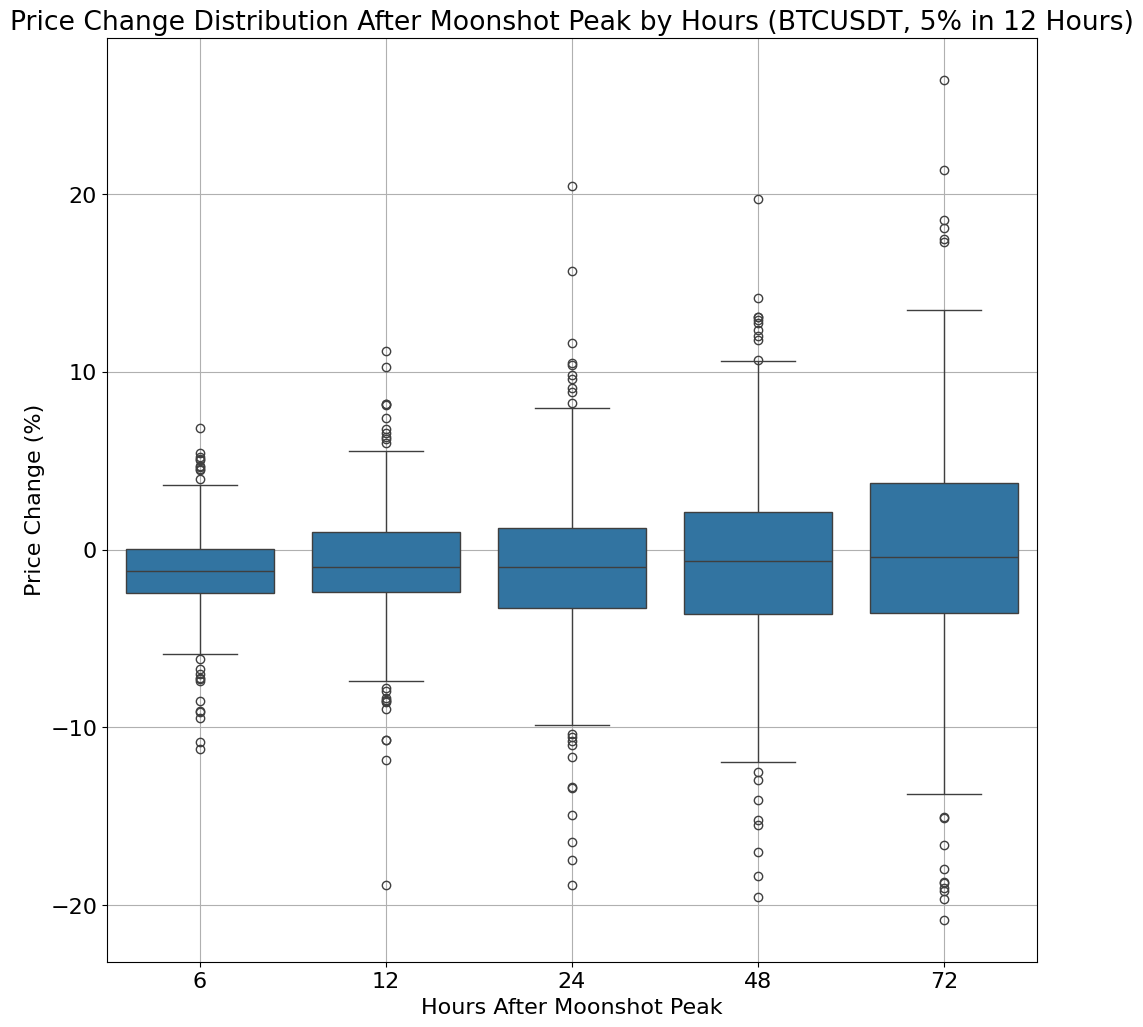

In [6]:
# 3. สร้าง Boxplot เพื่อแสดงการกระจายของ % การเปลี่ยนแปลง
plt.figure(figsize=(12, 12))
sns.boxplot(x='hours', y='price_change', data=price_changes)
plt.title('Price Change Distribution After Moonshot Peak by Hours (BTCUSDT, 5% in 12 Hours)')
plt.xlabel('Hours After Moonshot Peak')
plt.ylabel('Price Change (%)')
plt.grid(True)
plt.show()

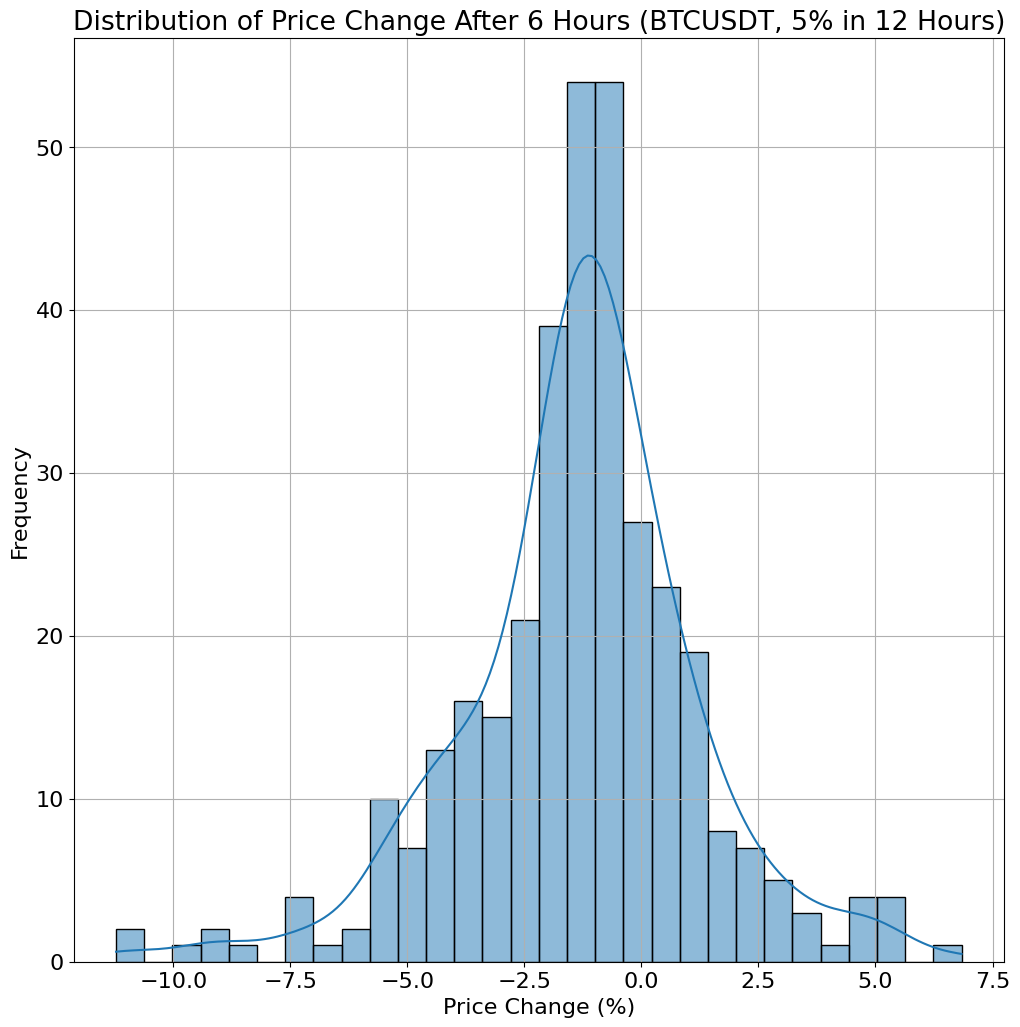

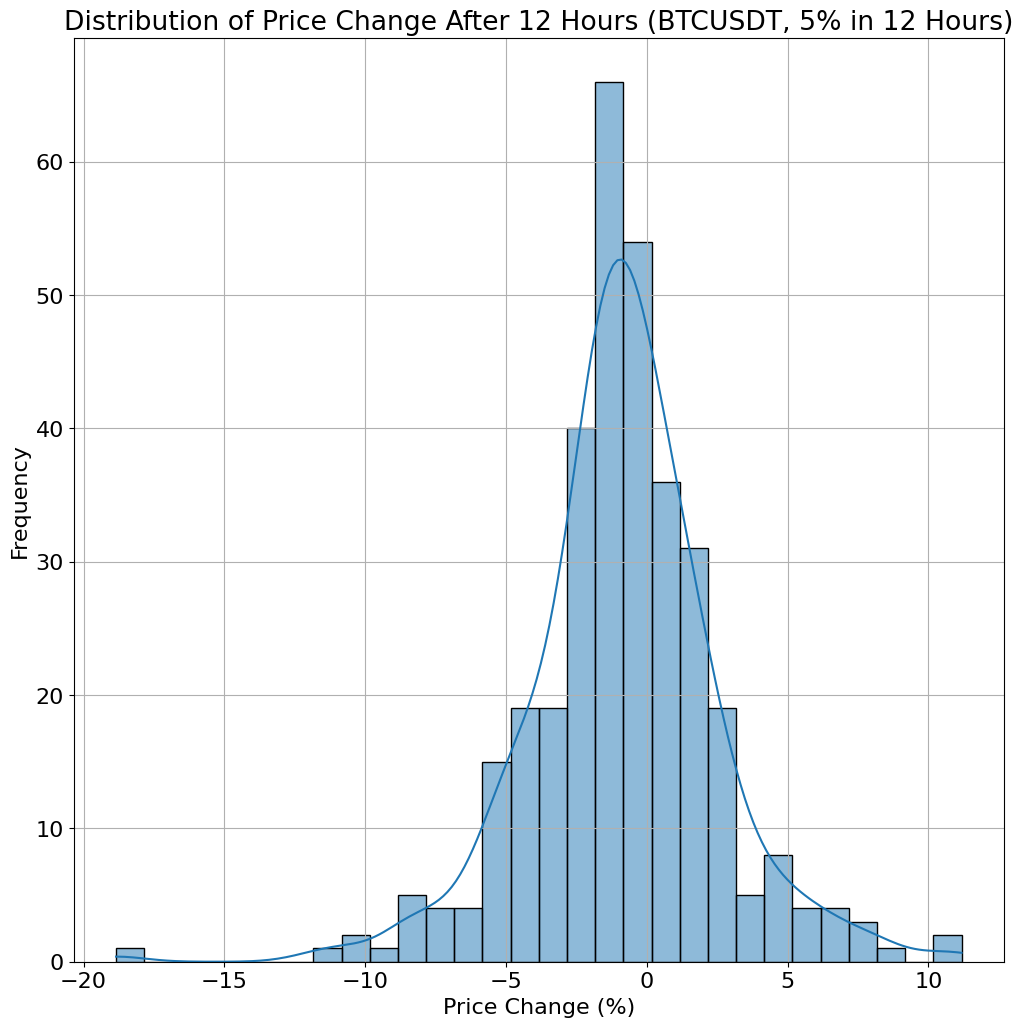

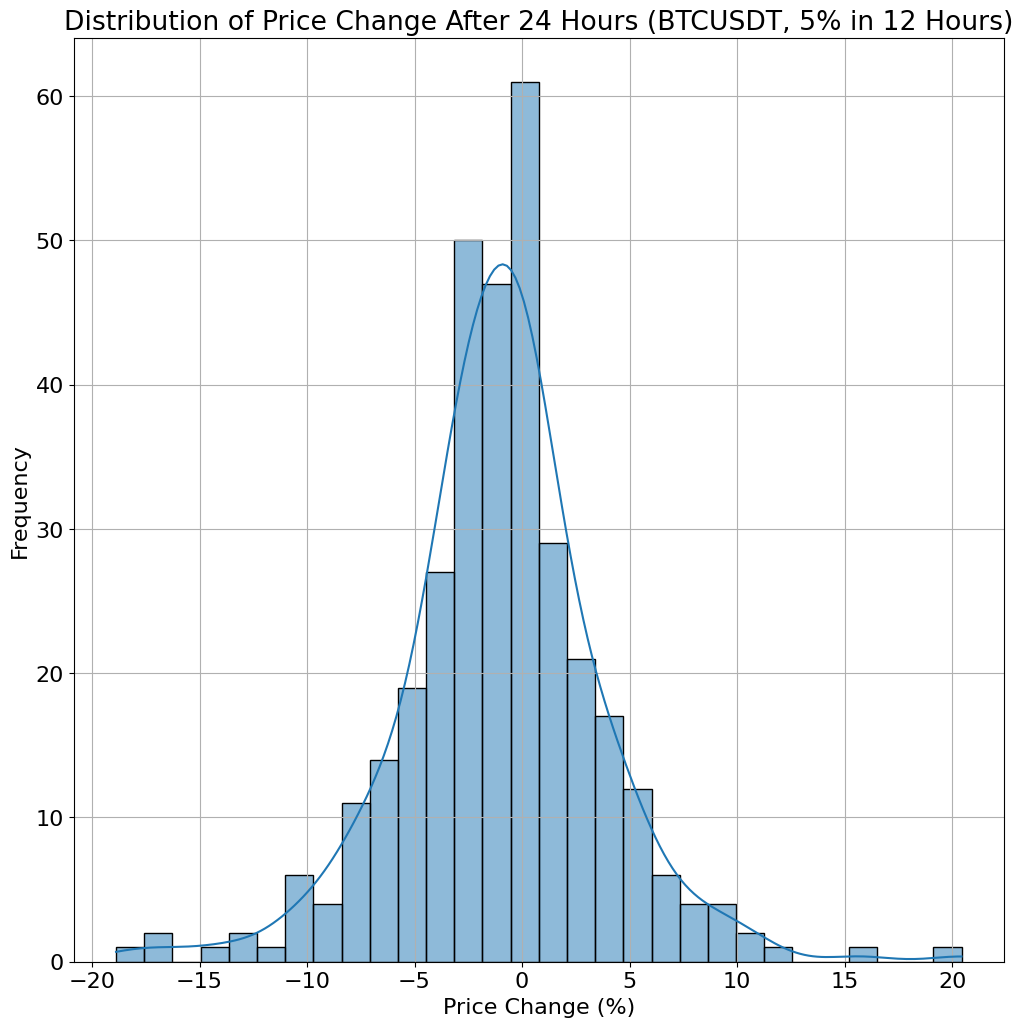

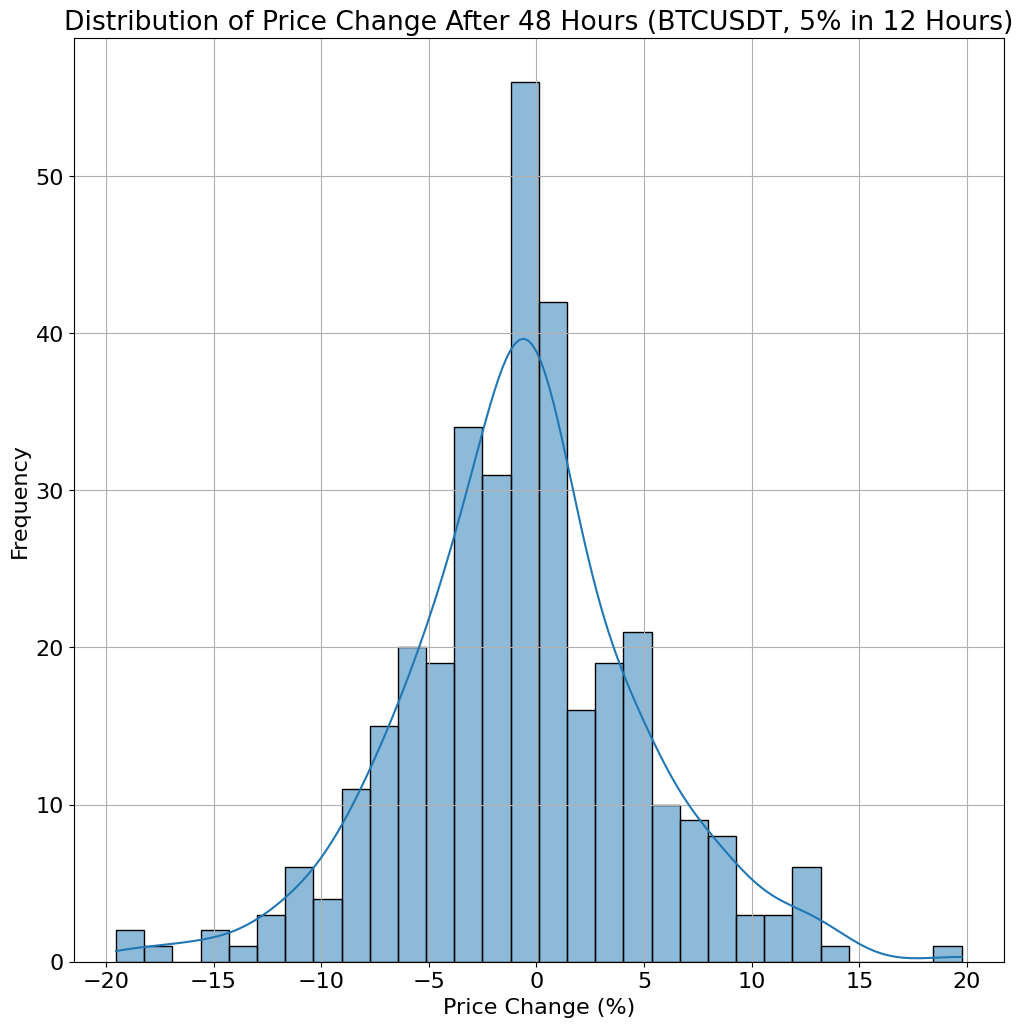

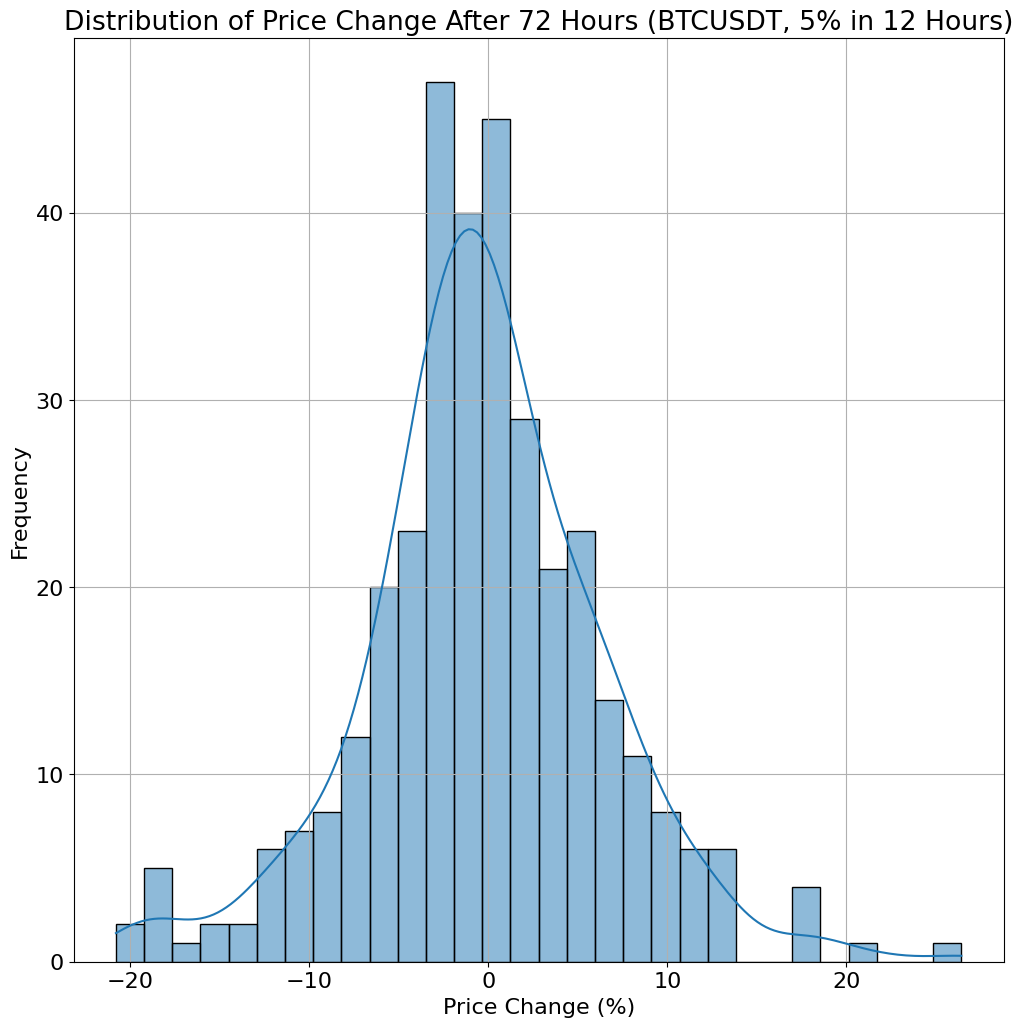

In [7]:
# 4. สร้าง Histogram สำหรับแต่ละช่วงเวลา
for h in post_hours:
    indicator = f'change_{h}h'
    plt.figure(figsize=(12, 12))
    sns.histplot(moonshots[indicator].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of Price Change After {h} Hours (BTCUSDT, 5% in 12 Hours)')
    plt.xlabel('Price Change (%)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [8]:
# 5. ทดสอบความปกติของการแจกแจง
for h in post_hours:
    indicator = f'change_{h}h'
    stat, p_value = stats.shapiro(moonshots[indicator].dropna().sample(min(5000, len(moonshots[indicator].dropna()))))
    print(f"\nShapiro-Wilk Test for Price Change After {h} Hours:")
    print(f"stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("The distribution is not normal (p < 0.05)")
    else:
        print("The distribution is normal (p >= 0.05)")


Shapiro-Wilk Test for Price Change After 6 Hours:
stat=0.9648, p-value=0.0000
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for Price Change After 12 Hours:
stat=0.9577, p-value=0.0000
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for Price Change After 24 Hours:
stat=0.9635, p-value=0.0000
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for Price Change After 48 Hours:
stat=0.9849, p-value=0.0012
The distribution is not normal (p < 0.05)

Shapiro-Wilk Test for Price Change After 72 Hours:
stat=0.9779, p-value=0.0000
The distribution is not normal (p < 0.05)
